# Lecture 4 – Data 100, Fall 2023

Data 100, Fall 2023

[Acknowledgments Page](https://ds100.org/fa23/acks/)

A demonstration of advanced `pandas` syntax to accompany Lecture 4.

In [1]:
import numpy as np
import pandas as pd
import plotly.express as px

## More on `Groupby`

### Slido Exercise

Try to predict the results of the `groupby` operation shown. The answer is below the image.

<img src="images/groupby.png" alt="Image" width="600">

The top ?? will be "hi", the second ?? will be "tx", and the third ?? will be "sd".

In [2]:
# create dataframe given below
data = {'x': [3, 1, 4, 1, 5, 9, 2, 5, 6],
        'y': ['ak', 'tx', 'fl', 'hi', 'mi', 'ak', 'ca', 'sd', 'nc']}

index = ['A', 'B', 'C', 'A', 'B', 'C', 'A', 'C', 'B']

df = pd.DataFrame(data, index=index)

df

,x,y
A,3,ak
B,1,tx
C,4,fl
A,1,hi
B,5,mi
C,9,ak
A,2,ca
C,5,sd
B,6,nc


In [3]:
import pandas as pd

# Create the DataFrame using a dictionary
data = {
    'x': ['A', 'B', 'C', 'A', 'B', 'C', 'A', 'C', 'B'],
    'y': [3, 1, 4, 1, 5, 9, 2, 5, 6],
    'z': ['ak', 'tx', 'fl', 'hi', 'mi', 'ak', 'ca', 'sd', 'nc']
}

df = pd.DataFrame(data)

# Print the DataFrame
df=df.set_index('x')
df

,y,z
x,,
A,3,ak
B,1,tx
C,4,fl
A,1,hi
B,5,mi
C,9,ak
A,2,ca
C,5,sd
B,6,nc


In [6]:
#Extract max value from each mini frame, like given below
df.groupby('x').agg(max)

,y,z
x,,
A,3,hi
B,6,tx
C,9,sd


### Loading `babynames` Dataset

In [4]:
import urllib.request
import os.path
import zipfile

data_url = "https://www.ssa.gov/oact/babynames/state/namesbystate.zip"
local_filename = "C:\\Users\\MOEED\Desktop\Knowledge Streams/babynamesbystate.zip"
if not os.path.exists(local_filename): # If the data exists don't download again
    with urllib.request.urlopen(data_url) as resp, open(local_filename, 'wb') as f:
        f.write(resp.read())

zf = zipfile.ZipFile(local_filename, 'r')

ca_name = 'STATE.CA.TXT'
field_names = ['State', 'Sex', 'Year', 'Name', 'Count']
with zf.open(ca_name) as fh:
    babynames = pd.read_csv(fh, header=None, names=field_names)

babynames.tail(10)

,State,Sex,Year,Name,Count
407418,CA,M,2022,Zach,5
407419,CA,M,2022,Zadkiel,5
407420,CA,M,2022,Zae,5
407421,CA,M,2022,Zai,5
407422,CA,M,2022,Zay,5
407423,CA,M,2022,Zayvier,5
407424,CA,M,2022,Zia,5
407425,CA,M,2022,Zora,5
407426,CA,M,2022,Zuriel,5
407427,CA,M,2022,Zylo,5


### Case Study: Name "Popularity"

In this exercise, let's find the name with sex "F" that has dropped most in popularity since its peak usage in California. We'll start by filtering `babynames` to only include names corresponding to sex "F".

In [5]:
# Code here
f_babynames=babynames[babynames['Sex']=='F']

In [6]:
# We sort the data by year
f_babynames.sort_values('Year')

,State,Sex,Year,Name,Count
0,CA,F,1910,Mary,295
148,CA,F,1910,Merle,9
149,CA,F,1910,Rosalie,9
150,CA,F,1910,Rosie,9
151,CA,F,1910,Teresa,9
...,...,...,...,...,...
237072,CA,F,2022,Johana,22
237073,CA,F,2022,Kit,22
237074,CA,F,2022,Korra,22
237076,CA,F,2022,Lavender,22


To build our intuition on how to answer our research question, let's visualize the prevalence of the name "Jennifer" over time.

In [7]:
# We'll talk about how to generate plots in a later lecture
jennifer_count= f_babynames[f_babynames['Name']=='Jennifer']
highest_count=jennifer_count['Count'].max()
# latest_count=jennifer_count.iloc[[-1]]
# latest_count
highest_count

6065

We'll need a mathematical definition for the change in popularity of a name in California.

Define the metric "Ratio to Peak" (RTP). We'll calculate this as the count of the name in 2022 (the most recent year for which we have data) divided by the largest count of this name in *any* year.

A demo calculation for Jennifer:

In [8]:
# In the year with the highest Jennifer count, 6065 Jennifers were born
highest_count=jennifer_count['Count'].max()
highest_count

6065

In [9]:
# Remember that we sorted f_babynames by year.
# This means that grabbing the final entry gives us the most recent count of Jennifers: 114
# In 2022, the most recent year for which we have data, 114 Jennifers were born
latest_count=jennifer_count['Count'].iloc[-1]
latest_count
#print(jennifer_count, "\n\n\n\n")

# lc = jennifer_count['Count'].iloc[-1]
# lc

114

In [10]:
# Compute the RTP
rtp=latest_count/highest_count
rtp

0.018796372629843364

We can also write a function that produces the `ratio_to_peak`for a given `Series`. This will allow us to use `.groupby` to speed up our computation for all names in the dataset.

In [11]:
def ratio_to_peak(series):
    return series.iloc[-1]/max(series)
    """
    Compute the RTP for a Series containing the counts per year for a single name
    """

In [102]:
# Construct a Series containing our Jennifer count data
jenn_counts_ser = f_babynames[f_babynames["Name"] == "Jennifer"]["Count"]

# Then, find the RTP
ratio_to_peak(jenn_counts_ser)

0.018796372629843364

Now, let's use `.groupby` to compute the RTPs for *all* names in the dataset.

You may see a warning message when running the cell below. As discussed in the lecture, `pandas` can't apply an aggregation function to non-numeric data (it doens't make sense to divide "CA" by a number). We can select numerical columns of interest directly.

,Year,Count
Name,,
Aadhini,1.0,1.000000
Aadhira,1.0,0.500000
Aadhya,1.0,0.660000
Aadya,1.0,0.586207
Aahana,1.0,0.269231
...,...,...
Zyanya,1.0,0.466667
Zyla,1.0,1.000000
Zylah,1.0,1.000000


In [12]:
# Results in a TypeError
rtp_table = f_babynames.groupby("Name")[['Count']].agg(ratio_to_peak)
rtp_table

,Count
Name,
Aadhini,1.000000
Aadhira,0.500000
Aadhya,0.660000
Aadya,0.586207
Aahana,0.269231
...,...
Zyanya,0.466667
Zyla,1.000000
Zylah,1.000000


This is the `pandas` equivalent of `.group` from [Data 8](http://data8.org/datascience/_autosummary/datascience.tables.Table.group.html). If we wanted to achieve this same result using the `datascience` library, we would write:

`f_babynames.group("Name", ratio_to_peak)`

### Slido Exercise

Is there a row where `Year` is not equal to 1?

In [13]:
# Unique values in the Year column
rtp_table = f_babynames.groupby("Name")[['Count','Year']].agg(ratio_to_peak)
rtp_table

,Count,Year
Name,,
Aadhini,1.000000,1.0
Aadhira,0.500000,1.0
Aadhya,0.660000,1.0
Aadya,0.586207,1.0
Aahana,0.269231,1.0
...,...,...
Zyanya,0.466667,1.0
Zyla,1.000000,1.0
Zylah,1.000000,1.0


In [14]:
# Dropping the Year column
rtp_table=rtp_table.drop('Year',axis='columns')

In [103]:
# Rename "Count" to "Count RTP" for clarity
rtp_table=rtp_table.rename(columns={'Count':'Count RTP'})
rtp_table

,Count RTP
Name,
Aadhini,1.000000
Aadhira,0.500000
Aadhya,0.660000
Aadya,0.586207
Aahana,0.269231
...,...
Zyanya,0.466667
Zyla,1.000000
Zylah,1.000000


In [115]:
# What name has fallen the most in popularity?
rtp_table.sort_values('Count RTP').head(1)

,Count RTP
Name,
Debra,0.00126


We can visualize the decrease in the popularity of the name "Debra:"

In [16]:
def plot_name(*names):
    fig = px.line(f_babynames[f_babynames["Name"].isin(names)],
                  x = "Year", y = "Count", color="Name",
                  title=f"Popularity for: {names}")
    fig.update_layout(font_size = 18,
                  autosize=False,
                  width=1000,
                  height=400)
    return fig

plot_name("Debra")

In [ ]:
# Find the 10 names that have decreased the most in popularity


Index(['Debra', 'Debbie', 'Carol', 'Tammy', 'Susan', 'Cheryl', 'Shannon',
       'Tina', 'Michele', 'Terri'],
      dtype='object', name='Name')

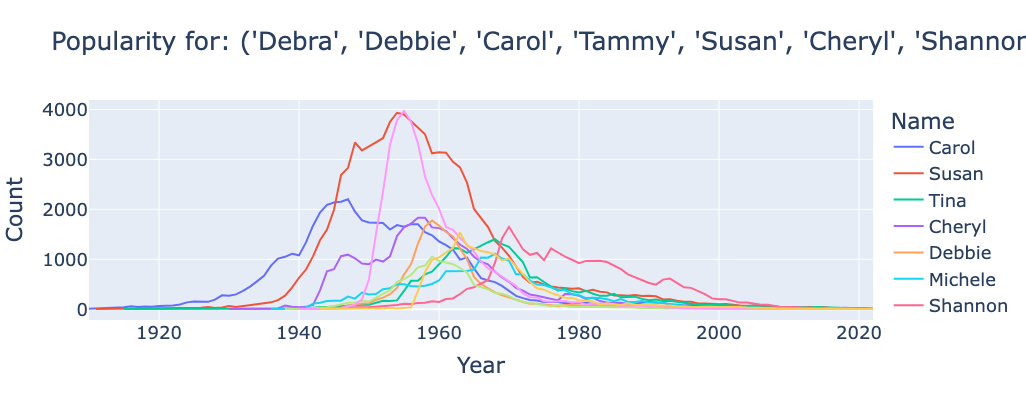

In [ ]:
plot_name(*top10)

For fun, try plotting your name or your friends' names.

### Slido Exercise

Given the example below on `babynames` dataset, write code to compute the total number of babies with each name in California.

In [18]:
babynames=babynames[babynames['State']=='CA']

### Slido Exercise

Write code to compute the total number of babies born each year in California.

In [19]:
babies_born=babynames.groupby('Year')[['Count']].agg(sum)

In [20]:
# Plotting baby counts per year
px.line(babies_born,y='Count')

### `groupby.size` and `groupby.count()`

In [28]:
df = pd.DataFrame({'letter':['A', 'A', 'B', 'C', 'C', 'C'],
                   'num':[1, 2, 3, 4, np.NaN, 4],
                   'state':[np.NaN, 'tx', 'fl', 'hi', np.NaN, 'ak']})
df 

,letter,num,state
0,A,1.0,NaN
1,A,2.0,tx
2,B,3.0,fl
3,C,4.0,hi
4,C,NaN,NaN
5,C,4.0,ak


In [37]:
df.groupby('letter').size()

letter
A    2
B    1
C    3
dtype: int64

In [38]:
df.groupby('letter').count()

,num,state
letter,,
A,2,1
B,1,1
C,2,2


`groupby.size()` returns a `Series`, indexed by the `letter`s that we grouped by, with values denoting the number of rows in each group/sub-DataFrame. It does not care about missing (`NaN`) values.

In [43]:
#code here
df.groupby('letter').size()

letter
A    2
B    1
C    3
dtype: int64

`groupby.count()` returns a `DataFrame`, indexed by the `letter`s that we grouped by. Each column represents the number of non-missing values for that `letter`.

In [44]:
# code here
df.groupby('letter').count()

,num,state
letter,,
A,2,1
B,1,1
C,2,2


You might recall `value_counts()` function we talked about last week. What's the difference?

In [45]:
# code here
df.value_counts()

letter  num  state
A       2.0  tx       1
B       3.0  fl       1
C       4.0  ak       1
             hi       1
Name: count, dtype: int64

Turns out `value_counts()` does something similar to `groupby.size()`, except that it also sorts the resulting `Series` in descending order.

## Filtering by Group

In [47]:
# Let's read the elections dataset
elections=pd.read_csv('elections (2).csv')

Let's keep only the elections years where the maximum vote share `%` is less than 45%.

In [127]:
# code here
elections[elections['%']<45]

,Year,Candidate,Party,Popular vote,Result,%
1,1824,John Quincy Adams,Democratic-Republican,113142,win,42.789878
3,1828,John Quincy Adams,National Republican,500897,loss,43.796073
5,1832,Henry Clay,National Republican,484205,loss,37.603628
6,1832,William Wirt,Anti-Masonic,100715,loss,7.821583
7,1836,Hugh Lawson White,Whig,146109,loss,10.005985
...,...,...,...,...,...,...
174,2016,Evan McMullin,Independent,732273,loss,0.539546
175,2016,Gary Johnson,Libertarian,4489235,loss,3.307714
177,2016,Jill Stein,Green,1457226,loss,1.073699
180,2020,Jo Jorgensen,Libertarian,1865724,loss,1.177979


In [106]:
 elections.groupby("Year").filter(lambda sf: sf["%"].max() < 45)

,Year,Candidate,Party,Popular vote,Result,%
23,1860,Abraham Lincoln,Republican,1855993,win,39.699408
24,1860,John Bell,Constitutional Union,590901,loss,12.639283
25,1860,John C. Breckinridge,Southern Democratic,848019,loss,18.138998
26,1860,Stephen A. Douglas,Northern Democratic,1380202,loss,29.522311
66,1912,Eugene V. Debs,Socialist,901551,loss,6.004354
67,1912,Eugene W. Chafin,Prohibition,208156,loss,1.386325
68,1912,Theodore Roosevelt,Progressive,4122721,loss,27.457433
69,1912,William Taft,Republican,3486242,loss,23.218466
70,1912,Woodrow Wilson,Democratic,6296284,win,41.933422
115,1968,George Wallace,American Independent,9901118,loss,13.571218


### `groupby` Puzzle

Assume that we want to know the best election by each party.

#### Attempt #1

We have to be careful when using aggregation functions. For example, the code below might be misinterpreted to say that Woodrow Wilson successfully ran for election in 2020. Why is this happening?

In [ ]:
#code here

,Year,Candidate,Popular vote,Result,%
Party,,,,,
American,1976,Thomas J. Anderson,873053,loss,21.554001
American Independent,1976,Lester Maddox,9901118,loss,13.571218
Anti-Masonic,1832,William Wirt,100715,loss,7.821583
Anti-Monopoly,1884,Benjamin Butler,134294,loss,1.335838
Citizens,1980,Barry Commoner,233052,loss,0.270182
Communist,1932,William Z. Foster,103307,loss,0.261069
Constitution,2016,Michael Peroutka,203091,loss,0.152398
Constitutional Union,1860,John Bell,590901,loss,12.639283
Democratic,2020,Woodrow Wilson,81268924,win,61.344703


In [79]:
elections.groupby('Party').max().head(10)

,Year,Candidate,Popular vote,Result,%
Party,,,,,
American,1976,Thomas J. Anderson,873053,loss,21.554001
American Independent,1976,Lester Maddox,9901118,loss,13.571218
Anti-Masonic,1832,William Wirt,100715,loss,7.821583
Anti-Monopoly,1884,Benjamin Butler,134294,loss,1.335838
Citizens,1980,Barry Commoner,233052,loss,0.270182
Communist,1932,William Z. Foster,103307,loss,0.261069
Constitution,2016,Michael Peroutka,203091,loss,0.152398
Constitutional Union,1860,John Bell,590901,loss,12.639283
Democratic,2020,Woodrow Wilson,81268924,win,61.344703


#### Attempt #2

Next, we'll write code that properly returns _the best result by each party_. That is, each row should show the Year, Candidate, Popular Vote, Result, and % for the election in which that party saw its best results (rather than mixing them as in the example above). Here's what the first rows of the correct output should look like:

![parties.png](attachment:ab21f8de-ad29-46c2-bea7-e9aea9c40e3e.png)

In [ ]:
# code here

,Year,Candidate,Party,Popular vote,Result,%
114,1964,Lyndon Johnson,Democratic,43127041,win,61.344703
91,1936,Franklin Roosevelt,Democratic,27752648,win,60.978107
120,1972,Richard Nixon,Republican,47168710,win,60.907806
79,1920,Warren Harding,Republican,16144093,win,60.574501
133,1984,Ronald Reagan,Republican,54455472,win,59.023326
84,1928,Herbert Hoover,Republican,21427123,win,58.368524
86,1932,Franklin Roosevelt,Democratic,22821277,win,57.672125
109,1956,Dwight Eisenhower,Republican,35579180,win,57.650654


In [104]:
# won_elections=elections[elections['Result']=='win']
sort=elections.sort_values('%', ascending=False )

In [ ]:
# code here


,Year,Candidate,Popular vote,Result,%
Party,,,,,
American,1856,Millard Fillmore,873053,loss,21.554001
American Independent,1968,George Wallace,9901118,loss,13.571218
Anti-Masonic,1832,William Wirt,100715,loss,7.821583
Anti-Monopoly,1884,Benjamin Butler,134294,loss,1.335838
Citizens,1980,Barry Commoner,233052,loss,0.270182
Communist,1932,William Z. Foster,103307,loss,0.261069
Constitution,2008,Chuck Baldwin,199750,loss,0.152398
Constitutional Union,1860,John Bell,590901,loss,12.639283
Democratic,1964,Lyndon Johnson,43127041,win,61.344703


In [114]:
elections_sorted_by_percent = elections.sort_values("%", ascending=False)
elections_sorted_by_percent.groupby("Party").agg(lambda x : x.iloc[0])

,Year,Candidate,Popular vote,Result,%
Party,,,,,
American,1856,Millard Fillmore,873053,loss,21.554001
American Independent,1968,George Wallace,9901118,loss,13.571218
Anti-Masonic,1832,William Wirt,100715,loss,7.821583
Anti-Monopoly,1884,Benjamin Butler,134294,loss,1.335838
Citizens,1980,Barry Commoner,233052,loss,0.270182
Communist,1932,William Z. Foster,103307,loss,0.261069
Constitution,2008,Chuck Baldwin,199750,loss,0.152398
Constitutional Union,1860,John Bell,590901,loss,12.639283
Democratic,1964,Lyndon Johnson,43127041,win,61.344703


In [105]:
sort.groupby('Party').first()

,Year,Candidate,Popular vote,Result,%
Party,,,,,
American,1856,Millard Fillmore,873053,loss,21.554001
American Independent,1968,George Wallace,9901118,loss,13.571218
Anti-Masonic,1832,William Wirt,100715,loss,7.821583
Anti-Monopoly,1884,Benjamin Butler,134294,loss,1.335838
Citizens,1980,Barry Commoner,233052,loss,0.270182
Communist,1932,William Z. Foster,103307,loss,0.261069
Constitution,2008,Chuck Baldwin,199750,loss,0.152398
Constitutional Union,1860,John Bell,590901,loss,12.639283
Democratic,1964,Lyndon Johnson,43127041,win,61.344703


In [113]:
best_per_party2 = elections.sort_values("%").drop_duplicates(["Party"], keep="last")
best_per_party2

,Year,Candidate,Party,Popular vote,Result,%
148,1996,John Hagelin,Natural Law,113670,loss,0.118219
164,2008,Chuck Baldwin,Constitution,199750,loss,0.152398
110,1956,T. Coleman Andrews,States' Rights,107929,loss,0.174883
147,1996,Howard Phillips,Taxpayers,184656,loss,0.192045
136,1988,Lenora Fulani,New Alliance,217221,loss,0.237804
89,1932,William Z. Foster,Communist,103307,loss,0.261069
127,1980,Barry Commoner,Citizens,233052,loss,0.270182
50,1896,John M. Palmer,National Democratic,134645,loss,0.969566
78,1920,Parley P. Christensen,Farmer–Labor,265398,loss,0.995804
42,1888,Alson Streeter,Union Labor,146602,loss,1.288861


#### Alternative Solutions

You'll soon discover that with Pandas rich tool set, there's typically more than one way to get to the same answer. Each approach has different tradeoffs in terms of readability, performance, memory consumption, complexity, and more. It will take some experience for you to develop a sense of which approach is better for each problem, but you should, in general, try to think if you can at least envision a different solution to a given problem, especially if you find your current solution to be particularly convoluted or hard to read.

Here are a couple of other ways of obtaining the same result (in each case, we only show the top part with `head()`). The first approach uses `groupby` but finds the location of the maximum value via the `idxmax()` method (look up its documentation!).  We then index and sort by `Party` to match the requested formatting:

In [ ]:
# code here

Party
American                  22
American Independent     115
Anti-Masonic               6
Anti-Monopoly             38
Citizens                 127
Communist                 89
Constitution             164
Constitutional Union      24
Democratic               114
Democratic-Republican      0
Dixiecrat                103
Farmer–Labor              78
Free Soil                 15
Green                    155
Greenback                 35
Independent              143
Liberal Republican        31
Libertarian              175
National Democratic       50
National Republican        3
National Union            27
Natural Law              148
New Alliance             136
Northern Democratic       26
Populist                  48
Progressive               68
Prohibition               49
Reform                   150
Republican               120
Socialist                 66
Southern Democratic       25
States' Rights           110
Taxpayers                147
Union                     93
Union La

In [116]:
 best_per_party = elections.loc[elections.groupby("Party")["%"].idxmax()]
best_per_party

,Year,Candidate,Party,Popular vote,Result,%
22,1856,Millard Fillmore,American,873053,loss,21.554001
115,1968,George Wallace,American Independent,9901118,loss,13.571218
6,1832,William Wirt,Anti-Masonic,100715,loss,7.821583
38,1884,Benjamin Butler,Anti-Monopoly,134294,loss,1.335838
127,1980,Barry Commoner,Citizens,233052,loss,0.270182
89,1932,William Z. Foster,Communist,103307,loss,0.261069
164,2008,Chuck Baldwin,Constitution,199750,loss,0.152398
24,1860,John Bell,Constitutional Union,590901,loss,12.639283
114,1964,Lyndon Johnson,Democratic,43127041,win,61.344703
0,1824,Andrew Jackson,Democratic-Republican,151271,loss,57.210122


In [119]:
# This is the computational part
abc=elections.loc[elections.groupby('Party')['%'].idxmax()]
# This indexes by Party to match the formatting above
abc.set_index('Party').head()

,Year,Candidate,Popular vote,Result,%
Party,,,,,
American,1856,Millard Fillmore,873053,loss,21.554001
American Independent,1968,George Wallace,9901118,loss,13.571218
Anti-Masonic,1832,William Wirt,100715,loss,7.821583
Anti-Monopoly,1884,Benjamin Butler,134294,loss,1.335838
Citizens,1980,Barry Commoner,233052,loss,0.270182


And this one doesn't even use `groupby`! This approach instead uses the `drop_duplicates` method to keep only the last occurrence of of each party after having sorted by "%", which is the best performance.  Again, the 2nd line is purely formatting:

In [ ]:
# code here


,Year,Candidate,Popular vote,Result,%
Party,,,,,
American,1856,Millard Fillmore,873053,loss,21.554001
American Independent,1968,George Wallace,9901118,loss,13.571218
Anti-Masonic,1832,William Wirt,100715,loss,7.821583
Anti-Monopoly,1884,Benjamin Butler,134294,loss,1.335838
Citizens,1980,Barry Commoner,233052,loss,0.270182


In [122]:
# This approach instead uses the drop_duplicates
elections.sort_values('Party').drop_duplicates(['Party'], keep='last')

,Year,Candidate,Party,Popular vote,Result,%
22,1856,Millard Fillmore,American,873053,loss,21.554001
119,1972,John G. Schmitz,American Independent,1100868,loss,1.421524
6,1832,William Wirt,Anti-Masonic,100715,loss,7.821583
38,1884,Benjamin Butler,Anti-Monopoly,134294,loss,1.335838
127,1980,Barry Commoner,Citizens,233052,loss,0.270182
89,1932,William Z. Foster,Communist,103307,loss,0.261069
164,2008,Chuck Baldwin,Constitution,199750,loss,0.152398
24,1860,John Bell,Constitutional Union,590901,loss,12.639283
10,1840,Martin Van Buren,Democratic,1128854,loss,46.948787
0,1824,Andrew Jackson,Democratic-Republican,151271,loss,57.210122


*Challenge:* See if you can find yet another approach that still gives the same answer.

### `DataFrameGroupBy` Objects

The result of `groupby` is not a `DataFrame` or a list of `DataFrame`s. It is instead a special type called a `DataFrameGroupBy`.

In [ ]:
# code here

pandas.core.groupby.generic.DataFrameGroupBy

In [129]:
grouped_by_party = elections.groupby("Party")

`GroupBy` objects are structured like dictionaries. In fact, we can actually see the dictionaries with the following code:

In [130]:
grouped_by_party.groups

{'American': [22, 126], 'American Independent': [115, 119, 124], 'Anti-Masonic': [6], 'Anti-Monopoly': [38], 'Citizens': [127], 'Communist': [89], 'Constitution': [160, 164, 172], 'Constitutional Union': [24], 'Democratic': [2, 4, 8, 10, 13, 14, 17, 20, 28, 29, 34, 37, 39, 45, 47, 52, 55, 57, 64, 70, 74, 77, 81, 83, 86, 91, 94, 97, 100, 105, 108, 111, 114, 116, 118, 123, 129, 134, 137, 140, 144, 151, 158, 162, 168, 176, 178], 'Democratic-Republican': [0, 1], 'Dixiecrat': [103], 'Farmer–Labor': [78], 'Free Soil': [15, 18], 'Green': [149, 155, 156, 165, 170, 177, 181], 'Greenback': [35], 'Independent': [121, 130, 143, 161, 167, 174], 'Liberal Republican': [31], 'Libertarian': [125, 128, 132, 138, 139, 146, 153, 159, 163, 169, 175, 180], 'National Democratic': [50], 'National Republican': [3, 5], 'National Union': [27], 'Natural Law': [148], 'New Alliance': [136], 'Northern Democratic': [26], 'Populist': [48, 61, 141], 'Progressive': [68, 82, 101, 107], 'Prohibition': [41, 44, 49, 51, 54,

The `key`s of the dictionary are the groups (in this case, `Party`), and the `value`s are the **indices** of rows belonging to that group. We can access a particular sub-`DataFrame` using `get_group`:

In [131]:
grouped_by_party.get_group("Socialist")

,Year,Candidate,Party,Popular vote,Result,%
58,1904,Eugene V. Debs,Socialist,402810,loss,2.985897
62,1908,Eugene V. Debs,Socialist,420852,loss,2.850866
66,1912,Eugene V. Debs,Socialist,901551,loss,6.004354
71,1916,Allan L. Benson,Socialist,590524,loss,3.194193
76,1920,Eugene V. Debs,Socialist,913693,loss,3.428282
85,1928,Norman Thomas,Socialist,267478,loss,0.728623
88,1932,Norman Thomas,Socialist,884885,loss,2.236211
92,1936,Norman Thomas,Socialist,187910,loss,0.412876
95,1940,Norman Thomas,Socialist,116599,loss,0.234237
102,1948,Norman Thomas,Socialist,139569,loss,0.286312


---

## Pivot Tables

### `Groupby` with multiple columns

We want to build a table showing the total number of babies born of each sex in each year. One way is to `groupby` using both columns of interest:

Count
Year Sex       
1910 F     5950
     M     3213
1911 F     6602
     M     3381
1912 F     9804
     M     8142

In [132]:
babynames.groupby(['Year','Sex'])[['Count']].agg(sum)

Count
Year Sex        
1910 F      5950
     M      3213
1911 F      6602
     M      3381
1912 F      9804
...          ...
2020 M    189119
2021 F    173913
     M    188669
2022 F    172454
     M    187569

[226 rows x 1 columns]

### `pivot_table`

Sex,F,M
Year,,
1910,5950,3213
1911,6602,3381
1912,9804,8142
1913,11860,10234
1914,13815,13111
1915,18643,17192


In [136]:
baby_pivot=babynames.pivot_table(
index='Year',
columns='Sex',
values=['Count'],
aggfunc=np.sum,
)
baby_pivot.head(6)

Count       
Sex       F      M
Year              
1910   5950   3213
1911   6602   3381
1912   9804   8142
1913  11860  10234
1914  13815  13111
1915  18643  17192

![pivot_picture.png](attachment:pivot_picture.png)

### `pivot_table` with Multiple values

Count          Name         
Sex      F     M       F        M
Year                             
1910   295   237  Yvonne  William
1911   390   214   Zelma   Willis
1912   534   501  Yvonne  Woodrow
1913   584   614   Zelma   Yoshio
1914   773   769   Zelma   Yoshio
1915   998  1033    Zita    Yukio

In [138]:
baby_pivot=babynames.pivot_table(
index='Year',
columns='Sex',
values=['Count','Name'],
aggfunc=np.max,
)
baby_pivot.head(6)

Count          Name         
Sex      F     M       F        M
Year                             
1910   295   237  Yvonne  William
1911   390   214   Zelma   Willis
1912   534   501  Yvonne  Woodrow
1913   584   614   Zelma   Yoshio
1914   773   769   Zelma   Yoshio
1915   998  1033    Zita    Yukio

---

## Join Tables

What if we want to know the popularity of presidential candidates' first names in California in 2022? What can we do?

,Year,Candidate,Party,Popular vote,Result,%
0,1824,Andrew Jackson,Democratic-Republican,151271,loss,57.210122
1,1824,John Quincy Adams,Democratic-Republican,113142,win,42.789878
2,1828,Andrew Jackson,Democratic,642806,win,56.203927
3,1828,John Quincy Adams,National Republican,500897,loss,43.796073
4,1832,Andrew Jackson,Democratic,702735,win,54.574789
5,1832,Henry Clay,National Republican,484205,loss,37.603628
6,1832,William Wirt,Anti-Masonic,100715,loss,7.821583
7,1836,Hugh Lawson White,Whig,146109,loss,10.005985
8,1836,Martin Van Buren,Democratic,763291,win,52.272472
9,1836,William Henry Harrison,Whig,550816,loss,37.721543


,State,Sex,Year,Name,Count
235835,CA,F,2022,Olivia,2178
235836,CA,F,2022,Emma,2080
235837,CA,F,2022,Camila,2046
235838,CA,F,2022,Mia,1882
235839,CA,F,2022,Sophia,1762
235840,CA,F,2022,Isabella,1733
235841,CA,F,2022,Luna,1516
235842,CA,F,2022,Sofia,1307
235843,CA,F,2022,Amelia,1289
235844,CA,F,2022,Gianna,1107


In [144]:
babynames_2022=babynames[babynames['Year']==2022]
babynames_2022.head(10)

,State,Sex,Year,Name,Count
235835,CA,F,2022,Olivia,2178
235836,CA,F,2022,Emma,2080
235837,CA,F,2022,Camila,2046
235838,CA,F,2022,Mia,1882
235839,CA,F,2022,Sophia,1762
235840,CA,F,2022,Isabella,1733
235841,CA,F,2022,Luna,1516
235842,CA,F,2022,Sofia,1307
235843,CA,F,2022,Amelia,1289
235844,CA,F,2022,Gianna,1107


,Year,Candidate,Party,Popular vote,Result,%,First Name
0,1824,Andrew Jackson,Democratic-Republican,151271,loss,57.210122,Andrew
1,1824,John Quincy Adams,Democratic-Republican,113142,win,42.789878,John
2,1828,Andrew Jackson,Democratic,642806,win,56.203927,Andrew
3,1828,John Quincy Adams,National Republican,500897,loss,43.796073,John
4,1832,Andrew Jackson,Democratic,702735,win,54.574789,Andrew
...,...,...,...,...,...,...,...
177,2016,Jill Stein,Green,1457226,loss,1.073699,Jill
178,2020,Joseph Biden,Democratic,81268924,win,51.311515,Joseph
179,2020,Donald Trump,Republican,74216154,loss,46.858542,Donald
180,2020,Jo Jorgensen,Libertarian,1865724,loss,1.177979,Jo


In [147]:
elections['Fisrt Name']= elections['Candidate'].str.split().str[0]
elections

,Year,Candidate,Party,Popular vote,Result,%,Fisrt Name
0,1824,Andrew Jackson,Democratic-Republican,151271,loss,57.210122,Andrew
1,1824,John Quincy Adams,Democratic-Republican,113142,win,42.789878,John
2,1828,Andrew Jackson,Democratic,642806,win,56.203927,Andrew
3,1828,John Quincy Adams,National Republican,500897,loss,43.796073,John
4,1832,Andrew Jackson,Democratic,702735,win,54.574789,Andrew
...,...,...,...,...,...,...,...
177,2016,Jill Stein,Green,1457226,loss,1.073699,Jill
178,2020,Joseph Biden,Democratic,81268924,win,51.311515,Joseph
179,2020,Donald Trump,Republican,74216154,loss,46.858542,Donald
180,2020,Jo Jorgensen,Libertarian,1865724,loss,1.177979,Jo


Unlike in Data 8, the join function is called `merge` in pandas. `join` in pandas does something slightly different—we won't talk about it in this class.

,Year_x,Candidate,Party,Popular vote,Result,%,First Name,State,Sex,Year_y,Name,Count
0,1824,Andrew Jackson,Democratic-Republican,151271,loss,57.210122,Andrew,CA,M,2022,Andrew,741
1,1828,Andrew Jackson,Democratic,642806,win,56.203927,Andrew,CA,M,2022,Andrew,741
2,1832,Andrew Jackson,Democratic,702735,win,54.574789,Andrew,CA,M,2022,Andrew,741
3,1824,John Quincy Adams,Democratic-Republican,113142,win,42.789878,John,CA,M,2022,John,490
4,1828,John Quincy Adams,National Republican,500897,loss,43.796073,John,CA,M,2022,John,490
...,...,...,...,...,...,...,...,...,...,...,...,...
147,2020,Donald Trump,Republican,74216154,loss,46.858542,Donald,CA,M,2022,Donald,33
148,2016,Evan McMullin,Independent,732273,loss,0.539546,Evan,CA,F,2022,Evan,11
149,2016,Evan McMullin,Independent,732273,loss,0.539546,Evan,CA,M,2022,Evan,488
150,2016,Hillary Clinton,Democratic,65853514,loss,48.521539,Hillary,CA,F,2022,Hillary,10


,Year_x,Candidate,Party,Popular vote,Result,%,First Name,State,Sex,Year_y,Name,Count
75,1892,Benjamin Harrison,Republican,5176108,loss,42.984101,Benjamin,CA,M,2022,Benjamin,1524
73,1884,Benjamin Butler,Anti-Monopoly,134294,loss,1.335838,Benjamin,CA,M,2022,Benjamin,1524
74,1888,Benjamin Harrison,Republican,5443633,win,47.858041,Benjamin,CA,M,2022,Benjamin,1524
46,1880,James Garfield,Republican,4453337,win,48.369234,James,CA,M,2022,James,1086
44,1880,James B. Weaver,Greenback,308649,loss,3.352344,James,CA,M,2022,James,1086
...,...,...,...,...,...,...,...,...,...,...,...,...
115,1964,Lyndon Johnson,Democratic,43127041,win,61.344703,Lyndon,CA,M,2022,Lyndon,6
92,1912,Woodrow Wilson,Democratic,6296284,win,41.933422,Woodrow,CA,M,2022,Woodrow,6
93,1916,Woodrow Wilson,Democratic,9126868,win,49.367987,Woodrow,CA,M,2022,Woodrow,6
76,1888,Clinton B. Fisk,Prohibition,249819,loss,2.196299,Clinton,CA,M,2022,Clinton,6
